In [1]:
from train import *
import numpy as np

/Users/mehran/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# generate random sequences with specific motifs
select_motifs = [
    "ATCTATCTCCCAGATAGAT".replace("T", "U"),
    "CGCCATC".replace("T", "U"),
    "CGGGTAATCCCG".replace("T", "U")
]

num_examples = 1000 # use 10,000 if you have access to GPU
np.random.seed(42)
alphabet = np.array(["A", "U", "C", "G"])
out_ar = np.zeros(num_examples, dtype="|U48")
motif_pos = np.zeros(num_examples)
resp_ar = np.array(["Bound"] * num_examples)
for i in range(num_examples):
    outseq = np.random.choice(alphabet, 48, replace=True)
    cur_motif = np.random.choice(select_motifs, 1)
    rand_pos = np.random.choice(np.arange(35), 1)[0]
    outseq[rand_pos:(rand_pos + len(cur_motif))] = np.array(list(cur_motif))
    out_ar[i] = "".join(list(outseq))
    motif_pos[i] = rand_pos

In [3]:
# generate random shuffles
num_examples_tune = int(num_examples * 9)
try:
    import ushuffle
    out_ar_neg = np.zeros(num_examples_tune, dtype="|U48")
    resp_ar_neg = np.array(["Unbound"] * num_examples_tune)
    j = 0
    for i in range(out_ar.shape[0]):
        curseq = out_ar[i].encode()
        shuffler = ushuffle.Shuffler(curseq, 2)
        for k in range(9):
            seqres = shuffler.shuffle()
            out_ar_neg[j] = seqres.decode()
            j += 1
except Exception:
    out_ar_neg = np.zeros(num_examples_tune, dtype="|U48")
    resp_ar_neg = np.array(["Unbound"] * num_examples_tune)
    for i in range(out_ar_neg.shape[0]):
        outseq = np.random.choice(alphabet, 48, replace=True)
        out_ar_neg[i] = "".join(list(outseq))

In [4]:
seqar = np.concatenate((out_ar, out_ar_neg), axis=0)
respar = np.concatenate((resp_ar, resp_ar_neg), axis=0)
ar_idxs = np.arange(seqar.shape[0])
np.random.shuffle(ar_idxs)
dict_data = {"Input": seqar[ar_idxs],
             "Response": respar[ar_idxs],
             "MFEs": np.zeros(seqar.shape[0])}
dict_data

{'Input': array(['CAUACUUCCUCGAACGCUAGUCCGCCGCCGAAUCAAGCGAUAAUCGGG',
        'AGGAACAAGGAUAAAACAGUUACUAGACCCUAACGCUACCGCGGUCCG',
        'UUUUCACUUGCCCGUAACGGCCUCUGAUCUGGUUUUGGUAGGAACACA', ...,
        'UCUACUUACCUAGUGGCAGCACAGACAUCUUACCGCAGGGAAAUGUAG',
        'GAUUCCAUGCAGCGCUGACGCAUCGUUGCGGGCGUUAGCAUCUUGGCU',
        'CUGUUGAGUUGUCGCCUGGUUACGCCUCGGGGUUUACUGAAUUGUAGG'], dtype='<U48'),
 'Response': array(['Unbound', 'Unbound', 'Unbound', ..., 'Unbound', 'Unbound',
        'Unbound'], dtype='<U7'),
 'MFEs': array([0., 0., 0., ..., 0., 0., 0.])}

In [5]:
outdir = "notebook_data"
os.makedirs(outdir, exist_ok=True)
joblibpath = os.path.join(outdir, "example_data.joblib")
joblib.dump(dict_data, joblibpath, compress=9)

['notebook_data/example_data.joblib']

In [6]:
tensordict = split_dict(joblibpath)
tensordict.keys()

Splitting Training into 0-6400
Splitting Tuning into 6400-8000
Splitting Validation into 8000-10000


dict_keys(['Training', 'Tuning', 'Validation'])

In [7]:
tensordict_train = tensordict["Training"]
torch.manual_seed(42)

In [8]:
# load the model
inputsize = 48
optim_name = "Adam"
lr = 0.001
kernel_size = 16
conv_width = 64
dp = 0.5
trainable = False  # for the fixed dilated layer
dil_start = 2
dil_end = 16
bulge_size = 2
binarize_fd = True
model_name = "Pythia"
disable_conv_dp = False
useRegConv = False
modelparams = get_model_params(
    inputsize, optim_name, lr, kernel_size, conv_width, dp,
    trainable, dil_start, dil_end, bulge_size, binarize_fd,
    model_name, disable_conv_dp)
modelparams

{'optimizer': 'Adam',
 'inputsize': 48,
 'lr': 0.001,
 'dp': 0.5,
 'conv_width': 64,
 'kernel': 16,
 'dilationTraining': False,
 'dil_start': 2,
 'dil_end': 16,
 'bulge_size': 2,
 'binarize_fd': True,
 'model_name': 'Pythia',
 'DisConvDP': False}

In [9]:
dictpaths = compile_paths(outdir, modelparams,
                          useRegConv=useRegConv)
chkpaths = dictpaths["chkpaths"] +\
    [dictpaths["bestpath"], dictpaths["modelpath"]]
print(chkpaths)
net, optimizer = load_model(
    inputsize, outdir, optim_name, lr, chkpaths,
    useRegConv, kernel_size, conv_width, dp, trainable,
    dil_start, dil_end, bulge_size, binarize_fd, model_name,
    disable_conv_dp)

['notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.001_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-16_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1/checkpoints/pythiaModel_optimizer-Adam_inputsize-48_lr-0.001_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-16_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1_0.pt', 'notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.001_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-16_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1/checkpoints/pythiaModel_optimizer-Adam_inputsize-48_lr-0.001_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-16_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1_1.pt', 'notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.001_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_d

Splitting Training into 0-6400
Splitting Tuning into 6400-8000
Splitting Validation into 8000-10000
Making notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.001_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-16_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1/2022-09-13_18modelTraining.log
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 0: Loss: 0.7421627336618851
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 1: Loss: 0.6268782481855276
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 2: Loss: 0.44718545952773825
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 3: Loss: 0.33963336212066364
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 4: Loss: 0.1272661273690815
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 5: Loss: 0.11061246994863816
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 6: Loss: 0.055811670539919665
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 7: Loss: 0.023107626456387188
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 8: Loss: 0.049853241391841094
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Epoch 9: Loss: 0.10818328354175069
Assessing Training


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


Assessing Tuning


/Users/mehran/Documents/software/pythia/src/rbp/train.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


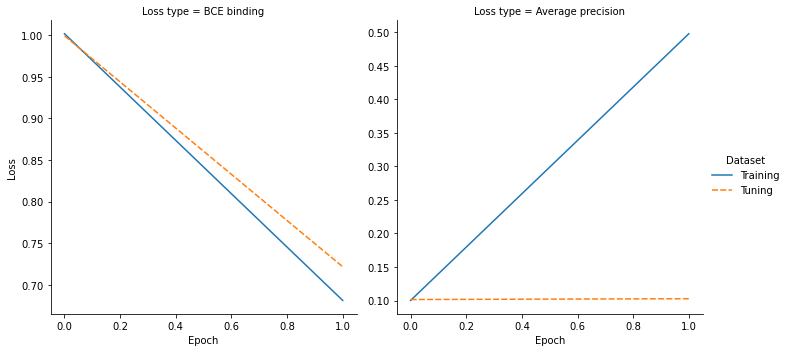

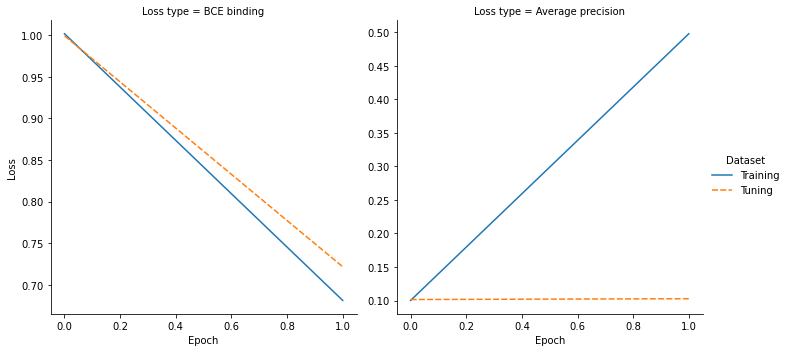

In [10]:
train_model(joblibpath, dictpaths, net, optimizer, model_name=model_name, MAXEPOCHS=10)

In [11]:
from predict import *

In [12]:
net.eval()
outpath = os.path.join(outdir, "model_performance.tsv.gz")
apply_model(
        joblibpath, net, outpath, model_name=model_name)

Splitting Training into 0-6400
Splitting Tuning into 6400-8000
Splitting Validation into 8000-10000


/Users/mehran/Documents/software/pythia/src/rbp/predict.py:250: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_m_soft = nn.functional.softmax(pred_m)


notebook_data/model_performance.tsv.gz


In [ ]:
# look into the output directory and examine the log file and model_performance.tsv.gz file